# Installation

In [1]:
!pip3 install xgboost
!pip3 install shap

# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.manifold import TSNE

import shap

# Main

In [3]:
df = pd.read_csv('smart_manufacturing_dataset.csv')
df = df.sort_values(by=["Machine_ID"])
df

,Machine_ID,Temperature (°C),Pressure (bar),Speed (RPM),Material Flow (kg/s),Kp,Ki,Kd,FLBC Output,System Oscillation (%),Predictive Maintenance Score,Equipment Health Index,Unplanned Downtime (min),Resource Utilization (%),Production Throughput (units/hr),Energy Consumption (kWh),System Response Time (ms),Error Rate (%),System_Status
1507,1,80.402301,1.701089,1366,10.499903,0.703518,0.034848,0.581976,1.604623,2.266907,0.795727,97,6,89.646291,81,50.450657,21,4.000755,Needs Maintenance
1536,1,54.861643,2.466920,1210,11.550597,1.040093,0.013224,0.813423,1.584921,2.258500,0.854576,84,4,96.980700,99,58.410156,19,4.293194,Unstable
1576,1,69.019029,3.198196,1171,11.945350,1.320552,0.037066,0.708838,1.401793,3.733484,0.692362,86,2,95.309819,127,56.591254,29,4.702397,Stable
1550,1,61.259487,1.586757,1433,10.655707,0.795325,0.026257,0.626753,1.486482,4.154396,0.742028,76,0,89.944138,91,55.168946,13,4.587307,Unstable
2578,1,54.808362,2.588978,1600,13.283812,1.130209,0.034393,0.650751,1.380420,3.645499,0.778946,86,2,87.954505,90,52.068972,23,3.391592,Stable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2271,99,72.534525,3.387111,1161,14.322070,0.975310,0.026788,0.885618,1.679970,3.500078,0.850286,76,7,87.732735,82,56.914306,22,4.117268,Needs Maintenance
2150,99,78.609905,1.960208,1629,19.315020,0.920953,0.024728,0.427306,1.286798,4.401886,0.676914,87,9,88.737020,104,52.366110,25,2.721983,Needs Maintenance
1998,99,83.728256,3.206207,1142,13.210198,0.765324,0.036093,0.647209,1.362411,3.924462,0.681366,78,9,87.064890,112,54.157841,13,1.023106,Stable
1453,99,72.296199,2.914031,1260,15.645906,1.163027,0.037163,0.945392,1.996949,4.160472,0.686166,77,2,85.639872,88,42.752595,20,1.492930,Stable


In [4]:
df.columns

Index(['Machine_ID', 'Temperature (°C)', 'Pressure (bar)', 'Speed (RPM)',
       'Material Flow (kg/s)', 'Kp', 'Ki', 'Kd', 'FLBC Output',
       'System Oscillation (%)', 'Predictive Maintenance Score',
       'Equipment Health Index', 'Unplanned Downtime (min)',
       'Resource Utilization (%)', 'Production Throughput (units/hr)',
       'Energy Consumption (kWh)', 'System Response Time (ms)',
       'Error Rate (%)', 'System_Status'],
      dtype='object')

In [5]:
Counter(df['System_Status'])

Counter({'Needs Maintenance': 1141, 'Unstable': 1141, 'Stable': 1141})

In [6]:
# There are 1 to 99 machine, split dataset into train/test via the machine ID
print(list(set(df['Machine_ID'].tolist())))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


# Split Data (Train/Test)

In [7]:
### Split by machine
# train_df = df[df["machine_id"].between(1, 80)]
# test_df  = df[df["machine_id"].between(81, 99)]

# target_col = "System_Status"

# X_train = train_df.drop(columns=[target_col, "Machine_ID", 'Error Rate (%)'])
# y_train = train_df[target_col]

# X_test = test_df.drop(columns=[target_col, "Machine_ID", 'Error Rate (%)'])
# y_test = test_df[target_col]

# le = LabelEncoder()

# y_train = le.fit_transform(y_train)
# y_test  = le.transform(y_test)

In [8]:
### Split randomly
target_col = "System_Status"
columns = [
    target_col, 
    "Machine_ID", 
    # 'Error Rate (%)'
    ]

X = df.drop(columns=columns, errors="ignore")
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y   # IMPORTANT for 3-class
)

le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test  = le.transform(y_test)

# Model Pipeline

In [9]:
# model = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", RandomForestClassifier(
#         n_estimators=300,
#         random_state=42,
#         class_weight="balanced"
#     ))
# ])

model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", XGBClassifier(
        objective="multi:softmax",
        num_class=3,
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="mlogloss",
        random_state=42
    ))
])

In [10]:
model.fit(X_train, y_train)

,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None


In [11]:
y_pred = model.predict(X_test)

In [12]:
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_micro = f1_score(y_test, y_pred, average="micro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")

print("F1 macro   :", f1_macro)
print("F1 micro   :", f1_micro)
print("F1 weighted:", f1_weighted)

F1 macro   : 0.3443783118577954
F1 micro   : 0.3445255474452555
F1 weighted: 0.3443643602033627


In [13]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[84 72 72]
 [79 77 72]
 [73 81 75]]


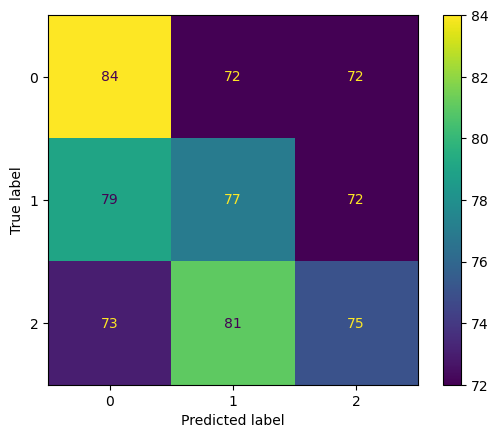

In [14]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# t-SNE

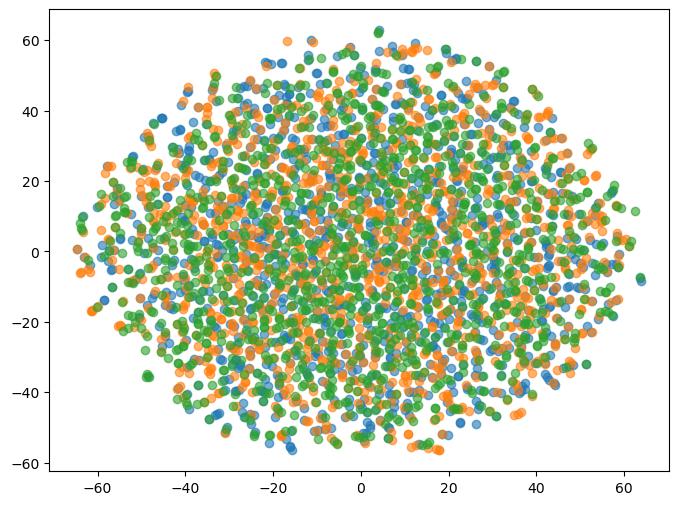

In [15]:
scaler = StandardScaler()
scaler.fit(X)
X_scale = scaler.transform(X)

y_enc = le.fit_transform(y)

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42
)

X_tsne = tsne.fit_transform(X_scale)

tsne_df = pd.DataFrame({
    "tsne_1": X_tsne[:, 0],
    "tsne_2": X_tsne[:, 1],
    "label": y_enc
})

plt.figure(figsize=(8, 6))
for i, label in enumerate(le.classes_):
    subset = tsne_df[tsne_df["label"] == i]
    plt.scatter(
        subset["tsne_1"],
        subset["tsne_2"],
        label=label,
        alpha=0.6
    )